<a href="https://colab.research.google.com/github/20Engma/Genetic-Algorithm-for-Optimizing-Wireless-Communications/blob/main/Genatic_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install deap


In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from deap import base, creator, tools, algorithms

In [10]:
# Load the data from the provided file
file_path = "Newdata.xlsx"
data = pd.read_excel(file_path)

In [11]:
# Constants for calculation
Er = 6378  # Earth radius in km
ht = 400    # Transmitter height in meters
angle = np.radians(10)  # Assuming a constant angle of 10 degrees, convert to radians

# Calculate distance for each row in the dataset
data['Distance'] = 2 * Er * np.arccos(Er / (Er + ht)) * np.cos(angle) - angle


In [12]:
# Split the data into features (X) and target (y)
X = data[['PL', 'RSS', 'SINR', 'Throughput']]
y = data['Distance']

In [13]:
# Normalize the features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

In [14]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [15]:
# Define and train the Neural Network
nn = MLPRegressor(hidden_layer_sizes=(10,), activation='relu', solver='adam', max_iter=500)
nn.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(10,), max_iter=500)

In [16]:
# Define and train the Neural Network
nn = MLPRegressor(hidden_layer_sizes=(10,), activation='relu', solver='adam', max_iter=500)
nn.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(10,), max_iter=500)

In [17]:
# Use the trained model to predict distances for X_test
y_pred_nn = nn.predict(X_test)


In [18]:
# Evaluate the model
nn_mse = mean_squared_error(y_test, y_pred_nn)
print("Neural Network MSE:", nn_mse)

nn_rmse = sqrt(nn_mse)
print("Neural Network RMSE:", nn_rmse)



Neural Network MSE: 17828204.017942466
Neural Network RMSE: 4222.345795638068


In [19]:
# Define the fitness function
def fitness_function(individual):
    # Map the values obtained from the genetic algorithm to the valid range for each parameter
    alpha = (individual[0] + 1) / 2  # Map [-1, 1] to [0, 1]
    beta_1 = (individual[1] + 1) / 2  # Map [-1, 1] to [0, 1]
    beta_2 = (individual[2] + 1) / 2  # Map [-1, 1] to [0, 1]
    epsilon = max(1e-7, (individual[3] + 1) / 2)  # Map [-1, 1] to [1e-7, inf)

    # Ensure parameters are within valid range
    alpha = max(0.0, min(1.0, alpha))
    beta_1 = max(0.0, min(0.999, beta_1))  # Ensure beta_1 is within [0.0, 0.999]
    beta_2 = max(0.0, min(0.999, beta_2))  # Ensure beta_2 is within [0.0, 0.999]

    # Set the parameters to the neural network
    nn.set_params(alpha=alpha, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

    # Train the neural network
    nn.fit(X_train, y_train)

    # Predict distances for the test set
    y_pred = nn.predict(X_test)

    # Calculate mean squared error
    mse = mean_squared_error(y_test, y_pred)

    return mse,

# Genetic Algorithm parameters
population_size = 50
num_generations = 10
mutation_prob = 0.2
crossover_prob = 0.8

# Create the toolbox for the GA
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=4)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define the genetic operators
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=mutation_prob)
toolbox.register("select", tools.selTournament, tournsize=3)

# Define training function with genetic algorithm
def train_genetic_algorithm():
    # Create initial population
    population = toolbox.population(n=population_size)

    # Evaluate the entire population
    fitnesses = [fitness_function(ind) for ind in population]
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # Evolve the population
    for gen in range(num_generations):
        offspring = algorithms.varAnd(population, toolbox, cxpb=crossover_prob, mutpb=mutation_prob)

        # Evaluate the offspring
        fitnesses = [fitness_function(ind) for ind in offspring]
        for ind, fit in zip(offspring, fitnesses):
            ind.fitness.values = fit

        # Select the next generation
        population[:] = toolbox.select(offspring, k=len(population))

    # Get the best individual
    best_individual = tools.selBest(population, k=1)[0]
    best_individual_values = [round(val, 2) for val in best_individual]

    # Print the best individual and its fitness value
    print("Best Individual:", best_individual_values)
    print("Best Fitness:", best_individual.fitness.values[0])

    return best_individual_values

# Run the genetic algorithm
best_params = train_genetic_algorithm()


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Best Individual: [0.18, 0.19, 2.77, 0.81]
Best Fitness: 16883710.182449564


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [21]:
# Define a function to evaluate and print performance metrics
def evaluate_performance():
    # Evaluate performance metrics for the neural network model
    # Predict distances for the test set
    y_pred_nn = nn.predict(X_test)

    # Calculate mean squared error
    mse_nn = mean_squared_error(y_test, y_pred_nn)

    # Print performance metrics for the neural network model
    print("Neural Network Performance Metrics:")
    print("Mean Squared Error (MSE):", mse_nn)

    # Evaluate performance metrics for the best individual obtained from the genetic algorithm
    # Map the best individual parameters to valid range
    best_alpha = (best_params[0] + 1) / 2
    best_beta_1 = max(0.0, min(0.999, (best_params[1] + 1) / 2))  # Ensure beta_1 is within [0.0, 0.999]
    best_beta_2 = max(0.0, min(0.999, (best_params[2] + 1) / 2))  # Ensure beta_2 is within [0.0, 0.999]
    best_epsilon = max(1e-7, (best_params[3] + 1) / 2)

    # Set the parameters to the neural network
    nn.set_params(alpha=best_alpha, beta_1=best_beta_1, beta_2=best_beta_2, epsilon=best_epsilon)

    # Train the neural network with best parameters
    nn.fit(X_train, y_train)

    # Predict distances for the test set using the best parameters
    y_pred_best = nn.predict(X_test)

    # Calculate mean squared error
    mse_best = mean_squared_error(y_test, y_pred_best)

    # Print performance metrics for the best individual obtained from the genetic algorithm
    print("\nGenetic Algorithm Performance Metrics (Best Individual):")
    print("Mean Squared Error (MSE):", mse_best)

# Call the function to evaluate performance
evaluate_performance()


Neural Network Performance Metrics:
Mean Squared Error (MSE): 17551519.44505026

Genetic Algorithm Performance Metrics (Best Individual):
Mean Squared Error (MSE): 18334568.788072146


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


# Show and Analysis result

### The relationship between distance and four different variables: PL, RSS, SINR, and Throughput.

Both actual values and predicted values (predicted by the model) are plotted to show how accurately the model predicts these values based on distance.

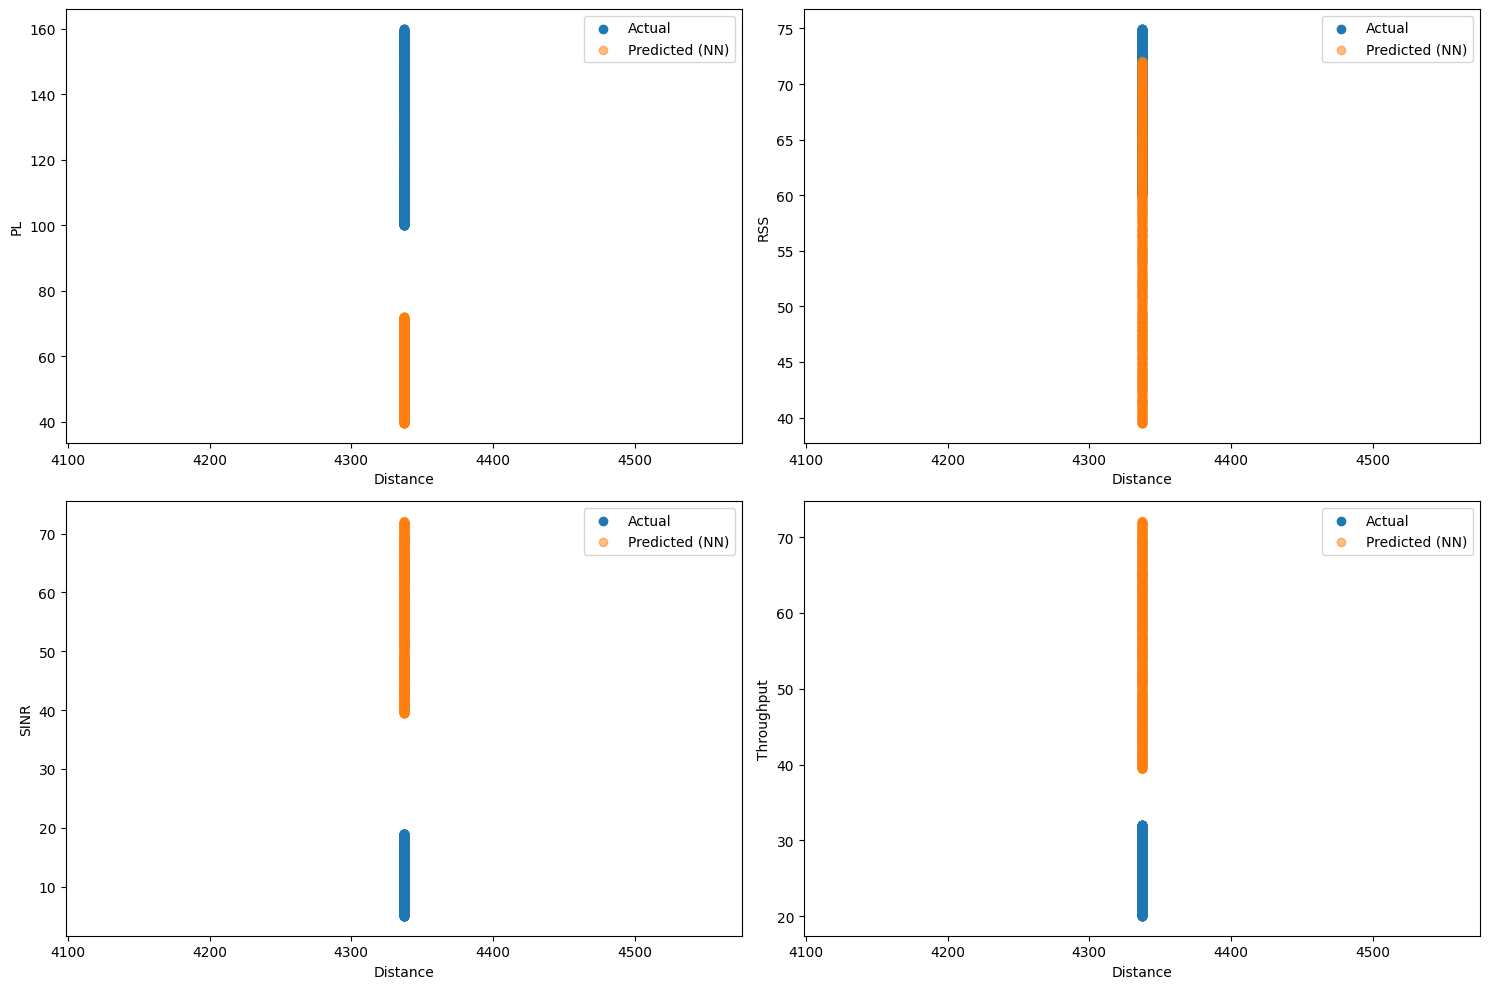

In [23]:
# Extract optimized parameters from the best individual
alpha_opt, beta_1_opt, beta_2_opt, epsilon_opt = best_params

# Set the optimized parameters to the neural network
nn.set_params(alpha=alpha_opt, beta_1=beta_1_opt, beta_2=beta_2_opt, epsilon=epsilon_opt)

# Plotting
import matplotlib.pyplot as plt

# Calculate predicted distances for the entire dataset
y_pred_nn_all = nn.predict(X_normalized)

# Plot PL, RSS, SINR, and Throughput versus Distance
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# PL vs. Distance
axs[0, 0].scatter(data['Distance'], data['PL'], label='Actual')
axs[0, 0].scatter(data['Distance'], y_pred_nn_all, label='Predicted (NN)', alpha=0.5)
axs[0, 0].set_xlabel('Distance')
axs[0, 0].set_ylabel('PL')
axs[0, 0].legend()

# RSS vs. Distance
axs[0, 1].scatter(data['Distance'], data['RSS'], label='Actual')
axs[0, 1].scatter(data['Distance'], y_pred_nn_all, label='Predicted (NN)', alpha=0.5)
axs[0, 1].set_xlabel('Distance')
axs[0, 1].set_ylabel('RSS')
axs[0, 1].legend()

# SINR vs. Distance
axs[1, 0].scatter(data['Distance'], data['SINR'], label='Actual')
axs[1, 0].scatter(data['Distance'], y_pred_nn_all, label='Predicted (NN)', alpha=0.5)
axs[1, 0].set_xlabel('Distance')
axs[1, 0].set_ylabel('SINR')
axs[1, 0].legend()

# Throughput vs. Distance
axs[1, 1].scatter(data['Distance'], data['Throughput'], label='Actual')
axs[1, 1].scatter(data['Distance'], y_pred_nn_all, label='Predicted (NN)', alpha=0.5)
axs[1, 1].set_xlabel('Distance')
axs[1, 1].set_ylabel('Throughput')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


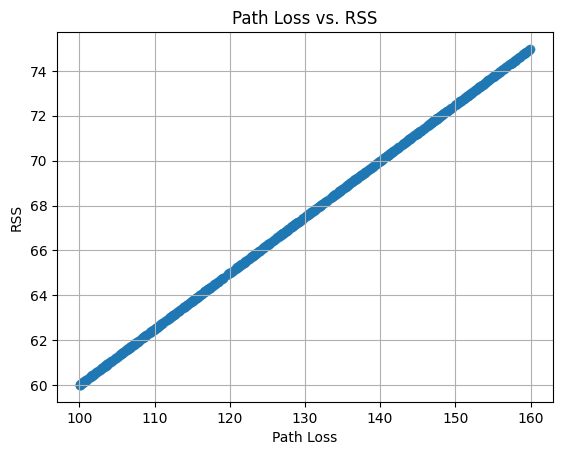

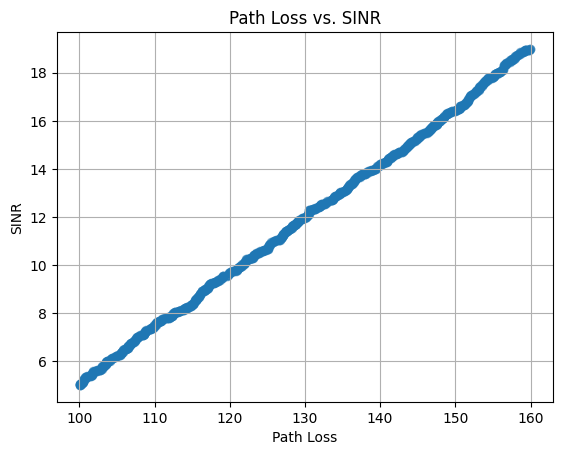

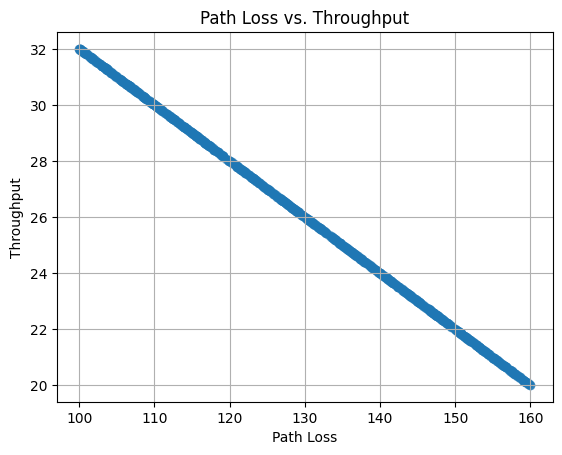

In [29]:
plt.scatter(data['PL'], data['RSS'], alpha=0.5)
plt.title('Path Loss vs. RSS')
plt.xlabel('Path Loss')
plt.ylabel('RSS')
plt.grid(True)
plt.show()

plt.scatter(data['PL'], data['SINR'], alpha=0.5)
plt.title('Path Loss vs. SINR')
plt.xlabel('Path Loss')
plt.ylabel('SINR')
plt.grid(True)
plt.show()

plt.scatter(data['PL'], data['Throughput'], alpha=0.5)
plt.title('Path Loss vs. Throughput')
plt.xlabel('Path Loss')
plt.ylabel('Throughput')
plt.grid(True)
plt.show()


In [30]:
# Find the row with the minimum Path Loss (PL)
best_pl_index = data['PL'].idxmin()
best_pl_parameters = data.iloc[best_pl_index]

# Print the best Path Loss parameters
print("Best Path Loss Parameters:")
print(best_pl_parameters)


Best Path Loss Parameters:
PL             100.029458
RSS             60.005510
SINR             5.011913
Throughput      32.000830
Distance      4337.125609
Name: 999, dtype: float64


# factor indicators

In [31]:
# Define a function to calculate average fitness
def average_fitness(population):
    total_fitness = sum(ind.fitness.values[0] for ind in population)
    return total_fitness / len(population)

# Define a function to calculate convergence
def convergence(population):
    best_fitness = min(ind.fitness.values[0] for ind in population)
    return best_fitness

# Define a function to calculate genetic diversity
def genetic_diversity(population):
    unique_individuals = {tuple(ind) for ind in population}
    return len(unique_individuals)

# Run the genetic algorithm while tracking metrics
def train_genetic_algorithm_with_metrics():
    # Initialize lists to store metrics
    optimal_values = []
    average_fitnesses = []
    convergence_values = []
    genetic_diversity_values = []

    # Create initial population
    population = toolbox.population(n=population_size)

    # Evaluate the entire population
    fitnesses = [fitness_function(ind) for ind in population]
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # Evolve the population
    for gen in range(num_generations):
        offspring = algorithms.varAnd(population, toolbox, cxpb=crossover_prob, mutpb=mutation_prob)

        # Evaluate the offspring
        fitnesses = [fitness_function(ind) for ind in offspring]
        for ind, fit in zip(offspring, fitnesses):
            ind.fitness.values = fit

        # Select the next generation
        population[:] = toolbox.select(offspring, k=len(population))

        # Record metrics for this generation
        optimal_values.append(min([ind.fitness.values[0] for ind in population]))
        average_fitnesses.append(average_fitness(population))
        convergence_values.append(convergence(population))
        genetic_diversity_values.append(genetic_diversity(population))

    # Get the best individual
    best_individual = tools.selBest(population, k=1)[0]
    best_individual_values = [round(val, 2) for val in best_individual]

    # Print the best individual and its fitness value
    print("Best Individual:", best_individual_values)
    print("Best Fitness:", best_individual.fitness.values[0])

    # Return all metrics
    return (optimal_values, average_fitnesses, convergence_values, genetic_diversity_values)

# Run the genetic algorithm while tracking metrics
metrics = train_genetic_algorithm_with_metrics()

# Extract individual metrics
optimal_values, average_fitnesses, convergence_values, genetic_diversity_values = metrics

# Print additional metrics
print("Optimal Value:", min(optimal_values))
print("Average Fitness:", average_fitnesses[-1])
print("Convergence:", convergence_values[-1])
print("Genetic Diversity:", genetic_diversity_values[-1])
print("Number of Generations:", num_generations)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Best Individual: [1.18, -0.03, 1.68, 0.63]
Best Fitness: 17147804.63202683
Optimal Value: 16666975.717609877
Average Fitness: 17617353.76639977
Convergence: 17147804.63202683
Genetic Diversity: 26
Number of Generations: 10


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
